# Creating a kml file for the Chile 2010 Tsunami propagation example

This notebook uses the same data as in [Chile2010_tsunami.ipynb](Chile2010_tsunami.ipynb), and illustrates how to turn a plot of the tsunami elevation into a kml file that can be viewed interactively, e.g. with Google Earth or Cesium.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import ma # masked arrays

from data_tools import read_asc_file

topo_file = '../geoclaw_output/chile2010/topo.asc'
topo_data_dict = read_asc_file(topo_file, verbose = False)

X = topo_data_dict['X']
Y = topo_data_dict['Y']
topo = topo_data_dict['values']

In [3]:
frame_times = np.linspace(0,5.5,12)
print "The data is at the following times (in hours after the earthquake):\n   ", frame_times

The data is at the following times (in hours after the earthquake):
    [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5]


First experiment with one time frame:

In [6]:
frameno = 9
filename = 'eta_%s.asc' % str(frameno).zfill(4)  # pads with zeros to fill 4 characters
eta_file = '../geoclaw_output/chile2010/%s' % filename
print 'Reading file %s\nTsunami simulation at time %4.1f hours after quake\n' \
    % (eta_file, frame_times[frameno])
eta_data_dict = read_asc_file(eta_file, verbose=False)
Eta = eta_data_dict['values']

Reading file ../geoclaw_output/chile2010/eta_0009.asc
Tsunami simulation at time  4.5 hours after quake



Mask Eta on shore to only show ocean surface:

In [5]:
Eta_offshore = ma.masked_where(topo>0, Eta)

We can choose a colormap and breakpoints.

Note that we set the colors to also contain a transparency alpha, so the elements of the list have the form [R,G,B,alpha].  We set `alpha = 0` for the range between `-0.05` and `0.05` so that the flat surface does not get colored at all, and to the value `alpha_wave` where the tsunami height is larger.

In [14]:
alpha_wave = 0.5
eta_colors_alpha = [[0,0,1,alpha_wave], [.5,.5,1,alpha_wave], \
                    [0,1,1,0], [1,.5,.5,alpha_wave], [1,0,0,alpha_wave]]
eta_levels = [-0.5,-0.1,-0.05,0.05,0.1,0.5]

## Create image suitable for displaying in kml file

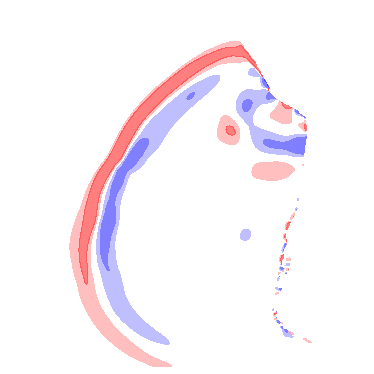

In [15]:
fig = plt.figure(figsize=(5,5))    # Figure is square

fname = 'chile'

plt.contourf(X,Y,Eta_offshore, eta_levels, colors=eta_colors_alpha, \
              extend='both')

fig.patch.set_alpha(0)
a = fig.gca()
a.set_position([0.,0.,1.0,1.0])
a.set_frame_on(False)
a.set_xticks([])
a.set_yticks([])
plt.axis('off')

kml_dpi = None
plt.savefig(fname + '.png', transparent=True, bbox_inches='tight', \
                    pad_inches=0,dpi=kml_dpi)



## Create kml file showing this image

In [16]:
from lxml import etree
from pykml.factory import KML_ElementMaker as KML

# Latlong box
x1 = -120   # east
x2 = -60    # west
y1 = -60    # south
y2 = 0.0    # north

# Create KML file using pyKML
doc = KML.kml(KML.Document())
doc.Document.append(KML.Folder(
          KML.GroundOverlay(KML.Icon(
                                KML.href(fname + '.png')),
                            KML.LatLonBox(
                                KML.north(y2),
                                KML.south(y1),
                                KML.east(x2),
                                KML.west(x1)))))

# doc.Document.Folder.append(go)
docfilename = "%s.kml" % fname
docfile = open(docfilename,'w')
docfile.write('<?xml version="1.0" encoding="UTF-8"?>\n')
kml_text = etree.tostring(etree.ElementTree(doc),pretty_print=True)
docfile.write(kml_text)
docfile.close()

print "Created %s" % docfilename

Created chile.kml


This kml file can be opened in Google Earth or other tools that support kml files.

### Cesium

Here we open it using [cesiumpy](https://pypi.python.org/pypi/cesiumpy), a Python wrapper for [cesium.js](http://cesiumjs.org/).

In [17]:
import cesiumpy
ds = cesiumpy.KmlDataSource('chile.kml')
v = cesiumpy.Viewer()
v.dataSources.add(ds)
v